In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('data for hw8/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
df.shape
df.head()

,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,500,501,502,503,504
0,2890276,357,113,500,14820,14823,14824,14822,14818,14820,...,14822,14815,14815,14817,14819,14820,14822,14820,14819,NaN
1,4928764,740,359,500,14820,14822,14820,14826,14824,14822,...,14817,14824,14822,14824,14819,14820,14819,14822,14820,NaN
2,9630204,162,499,500,14820,14820,14822,14825,14820,14824,...,14821,14820,14820,14818,14821,14823,14820,14820,14821,NaN
3,15798632,841,123,500,14828,14822,14818,14824,14824,14822,...,14826,14822,14821,14820,14828,14820,14822,14823,14822,NaN
4,20637296,412,348,500,14823,14815,14823,14821,14827,14820,...,14820,14823,14828,14824,14820,14824,14824,14822,14825,NaN


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23479 entries, 0 to 23478
Columns: 505 entries, 0 to 504
dtypes: float64(1), int64(504)
memory usage: 90.5 MB


In [20]:
df.duplicated().sum()

np.int64(0)

In [21]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

504    23479
dtype: int64

In [22]:
df = df.drop(504, axis=1)

In [45]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,494,495,496,497,498,499,500,501,502,503
0,2890276,357,113,500,14820,14823,14824,14822,14818,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,4928764,740,359,500,14820,14822,14820,14826,14824,14822,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,9630204,162,499,500,14820,14820,14822,14825,14820,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,15798632,841,123,500,14828,14822,14818,14824,14824,14822,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,20637296,412,348,500,14823,14815,14823,14821,14827,14820,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825
5,22773382,1310,61,500,14825,14820,14822,14824,14823,14823,...,14823,14823,14817,14820,14813,14819,14821,14820,14828,14822
6,26520366,1154,195,500,14824,14820,14818,14824,14820,14823,...,14816,14818,14820,14820,14823,14818,14824,14826,14821,14818
7,70574842,1904,31,500,14824,14820,14825,14823,14824,14826,...,14824,14820,14823,14824,14826,14824,14821,14824,14826,14820
8,73301918,1083,397,500,14824,14818,14823,14820,14828,14824,...,14822,14819,14824,14822,14821,14820,14819,14820,14823,14824
9,74388134,1654,391,500,14825,14824,14821,14820,14821,14824,...,14817,14819,14823,14824,14820,14818,14816,14823,14822,14816


In [5]:
signal_len = 500
baseline_samples = 50
def process_signal(signal):
    signal = np.array(signal)
    baseline = signal[:baseline_samples].mean()
    s = signal - baseline
    s = -s
    amp = s.max()
    if amp <= 0:
        return None
    thr = 0.4 * amp
    idx_start = np.argmax(s > thr)
    window = s[idx_start:idx_start + 200]
    total_integral = window.sum()
    tail_integral = window[50:].sum()

    psd = tail_integral / total_integral if total_integral != 0 else 0
    decay_idx = np.where(window < 0.1 * amp)[0]
    decay_time = decay_idx[0] if len(decay_idx) > 0 else len(window)
    return amp, total_integral, psd, decay_time

In [6]:
features = []
indices = []

for i, row in df.iterrows():
    signal = row[-signal_len:]
    res = process_signal(signal)

    if res is not None:
        features.append(res)
        indices.append(i)

features = pd.DataFrame(
    features,
    columns=["amplitude", "integral", "psd", "decay_time"]
)

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [28]:
def plot_pca_clusters(X_pca, labels, title):
    plt.figure(figsize=(7, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [29]:
def clustering_metrics(X, labels):
    mask = labels != -1

    if len(set(labels[mask])) < 2:
        return np.nan, np.nan

    sil = silhouette_score(X[mask], labels[mask])
    return sil

In [30]:
def fit_cluster_model(model, X):
    labels = model.fit_predict(X)
    return labels

In [31]:
def normalize_labels(labels):
    unique = np.unique(labels)
    mapping = {old: new for new, old in enumerate(unique)}
    return np.array([mapping[l] for l in labels])

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [33]:
def pca_cut(X_pca, axis=0, threshold=0.0):
    return (X_pca[:, axis] > threshold).astype(int)

In [34]:
def kmeans_func(X_pca, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    return fit_cluster_model(model, X_pca)

In [35]:
def dbscan_func(X_pca, eps=0.5, min_samples=20):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    return fit_cluster_model(model, X_pca)

In [40]:
methods = {
    "PCA cut": lambda X: pca_cut(X),
    "KMeans": lambda X: kmeans_func(X),
    "DBSCAN": lambda X: dbscan_func(X)
}

PCA cut         | Silhouette: 0.3591


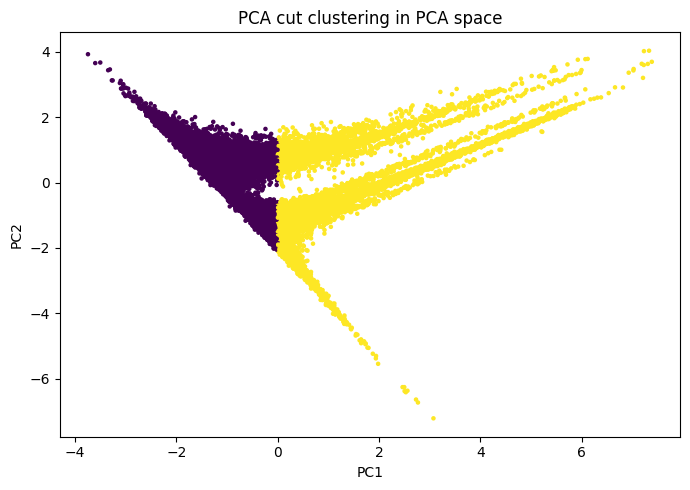

KMeans          | Silhouette: 0.4236


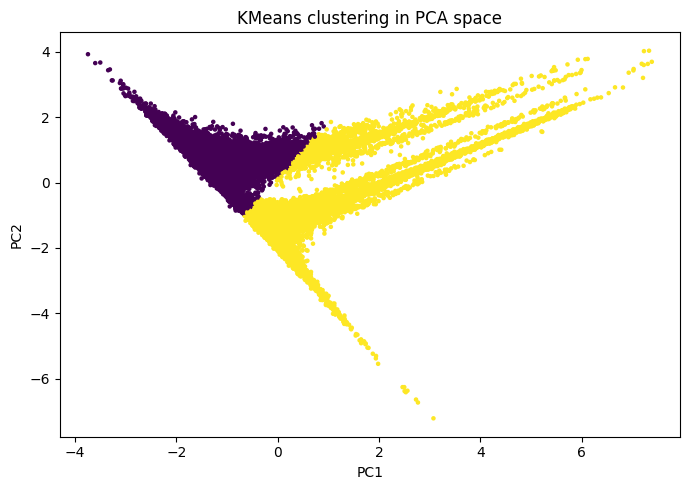

DBSCAN          | Silhouette: nan


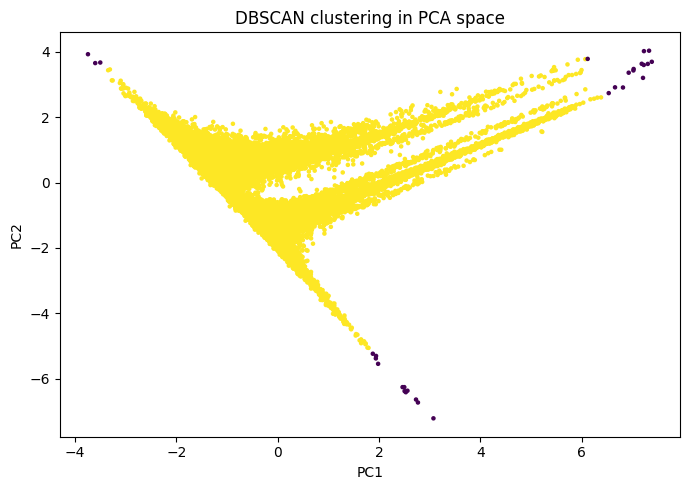

In [47]:
results = {}

for name, method in methods.items():
    labels = method(X_pca)
    sil, ch = clustering_metrics(X_pca, labels)

    results[name] = {
        "Silhouette": sil
    }

    print(f"{name:15s} | Silhouette: {sil:.4f}")

    plot_pca_clusters(X_pca, labels, f"{name} clustering in PCA space")

    labels_norm = normalize_labels(labels)

    submission = pd.DataFrame({
        "index": indices,
        "cluster": labels_norm
    }).sort_values("index")

    submission.to_csv(f"submission_{name}.csv", index=False)